# Analysis examples

In this notebook we'll show examples of how you might use the predictions exported from SLEAP. We'll work with an [Analysis HDF5](https://sleap.ai/tutorials/analysis.html) file (rather than the `.slp` predictions file). This HDF5 file can be exported from SLEAP.

We advise building your post-SLEAP analysis pipeline around these HDF5 files rather than trying to work directly with the `.slp` files used by SLEAP.

**Note**: You can work with these HDF5 directly in Python (as we'll do here) or MATLAB without having SLEAP itself installed.

## Example analysis data

You can follow along in this analysis by downloading the blue_whale.analysis.h5 files in this repo. You can either work locally in a Jupyter Notebook or on Google Drive via Google Colab.

We'll just download the `blue_whale.analysis.h5` file:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir("gdrive/My Drive/Colab Notebooks/sleap")

We can set the path and filename to the analysis HDF5. In our case, this is just `blue_whale.analysis.h5`. If you're running analysis code on your local computer this will be the full path and filename of your HDF5. If you're running analysis code on Colab, then you'll probably copy files to Colab via Google Drive and should use the path to your file there.

In [3]:
filename = "blue_whale.analysis.h5"

## Loading the data

We use the [h5py](https://www.h5py.org) package to load data from the HDF5. This is already installed in Colab. If your running analysis code on your local machine and have SLEAP installed, then `h5py` and other packages we use are already installed in your SLEAP conda environment. Otherwise, you may need to use `conda` or `pip` to install `h5py` as well as `numpy`, `scipy`, `matplotlib`, `seaborn`, and any other packages you want use in your analysis code.

Let's load the file and take a peek.

In [4]:
import h5py
import numpy as np

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
blue_whale.analysis.h5

===HDF5 datasets===
['instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']

===locations data shape===
(3033, 8, 2, 1)

===nodes===
0: head
1: blowhole
2: r_fin
3: l_fin
4: dorsal
5: r_tail
6: mid_tail
7: l_tail



In our example file, the shape of the locations matrix (the `tracks` dataset) is (3033, 8, 2, 1) **after it is transposed** (with the `.T`). We transpose the data when loading it in Python; no transpose is needed when using MATLAB. This is because Python and MATLAB expect matrices to be stored differently.

Here's what each dimension of the matrix means:

- 3033: the number of frames;

- 8: the number of nodes in the skeleton (we've also loaded and displayed the `node_names` dataset with the names of these 13 nodes);

- 2: for the x and y coordinates;

- 1: the number of distinct animal identities which were found (we have 1 blue whale in the video clip).

We can get these counts from the shape of the matrix, like so:


In [5]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 3033
node count: 8
instance count: 1


Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

In [6]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))
    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]
        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        if(x.shape[0]==0):
          continue
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])
        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)
    
    return Y

In [7]:
locations = fill_missing(locations)

## Visualize blowhole movement across video

In [8]:
HEAD_INDEX = 0
BLOW_INDEX = 1
DORSAL_INDEX = 4

head_loc = locations[:, HEAD_INDEX, :, :]
blow_loc = locations[:, BLOW_INDEX, :, :]
dorsal_loc = locations[:, DORSAL_INDEX, :, :]

In [9]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [10]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Blowhole tracks')

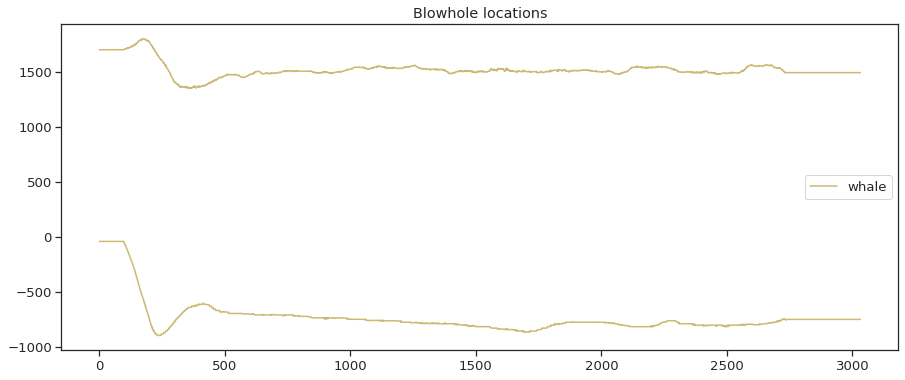

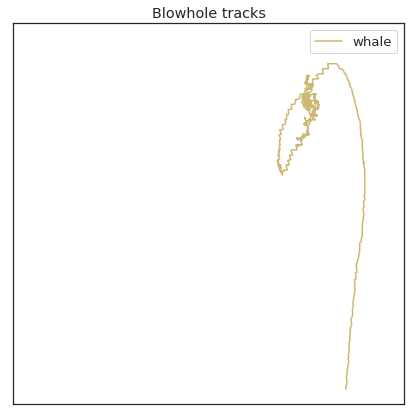

In [11]:
plt.figure()
plt.plot(blow_loc[:,0,0], 'y',label='whale')

plt.plot(-1*blow_loc[:,1,0], 'y')
#plt.plot(-1*blow_loc[:,1,1], 'g')

plt.legend(loc="center right")
plt.title('Blowhole locations')


plt.figure(figsize=(7,7))
plt.plot(blow_loc[:,0,0],blow_loc[:,1,0], 'y',label='whale')
plt.legend()

plt.xlim(0,2000)
plt.xticks([])

plt.ylim(0,1000)
plt.yticks([])
plt.title('Blowhole tracks')

## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [12]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two flies. Let's get results for each separately.

In [13]:
blow_vel = smooth_diff(blow_loc[:, :, 0])

### Visualizing blowhole x-y dynamics and velocity for whale

Text(0.5, 1.0, 'Velocity')

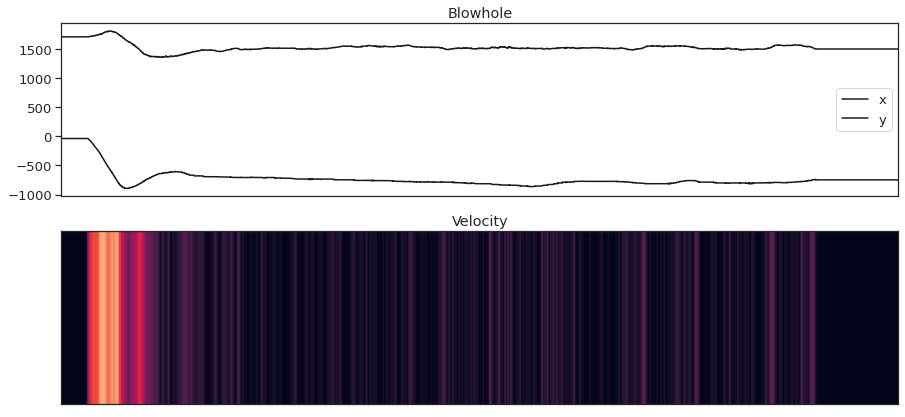

In [14]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(blow_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*blow_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Blowhole')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(blow_vel[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of whale

Text(0.5, 1.0, 'Blowhole tracks colored by Velocity')

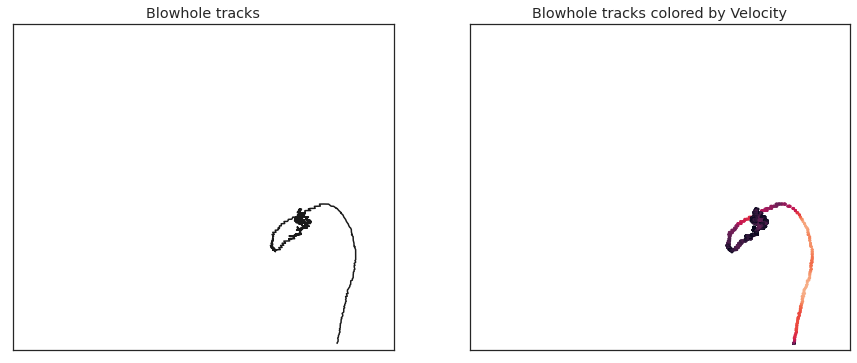

In [15]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(blow_loc[:, 0, 0], blow_loc[:, 1, 0], 'k')
ax1.set_xlim(0,2000)
ax1.set_xticks([])
ax1.set_ylim(0,2000)
ax1.set_yticks([])
ax1.set_title('Blowhole tracks')

kp = blow_vel 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(blow_loc[:,0,0], blow_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,2000)
ax2.set_xticks([])
ax2.set_ylim(0,2000)
ax2.set_yticks([])
ax2.set_title('Blowhole tracks colored by Velocity')

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run simple k-means on the velocities from each frame.


In [16]:
def instance_node_velocities(instance_idx):
    node_locations = locations[:, :, :, instance_idx]
    node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        node_velocities[:, n] = smooth_diff(node_locations[:, n, :])
    
    return node_velocities

In [17]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Node velocities')

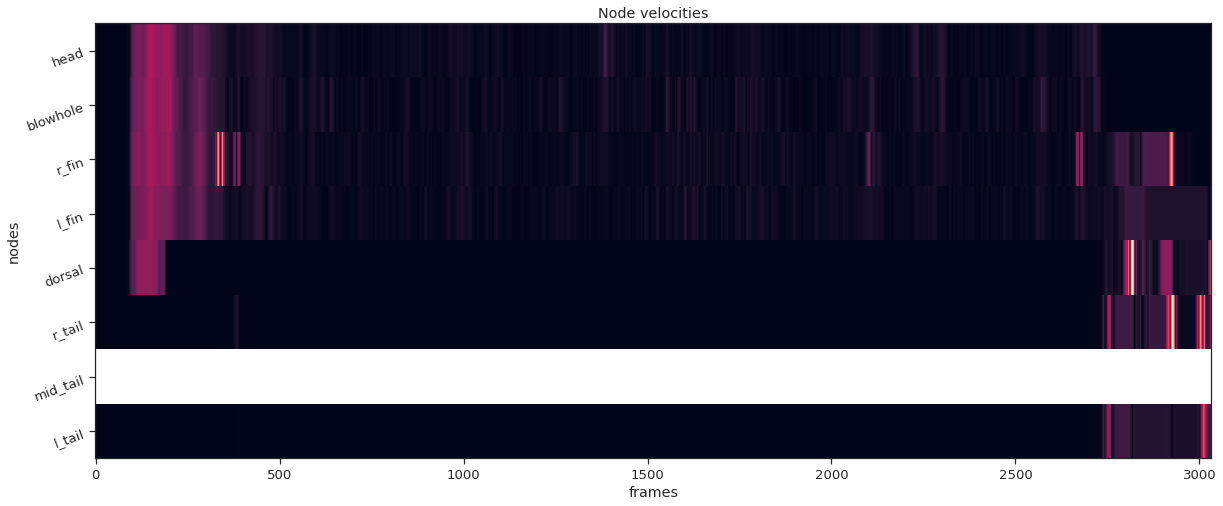

In [18]:
ID = 0
node_velocities = instance_node_velocities(ID)
plot_instance_node_velocities(ID, node_velocities)

In [19]:
from sklearn.cluster import KMeans

In [20]:
#Where ever the velocity is nan, we need to put in the average velocity of that node
node_velocities.mean(axis=0)
node_velocities = np.delete(node_velocities, obj=6, axis=1)
node_velocities.shape

(3033, 7)

In [21]:
node_names = np.delete(node_names, obj=6)
node_count = 7

In [22]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(node_velocities)

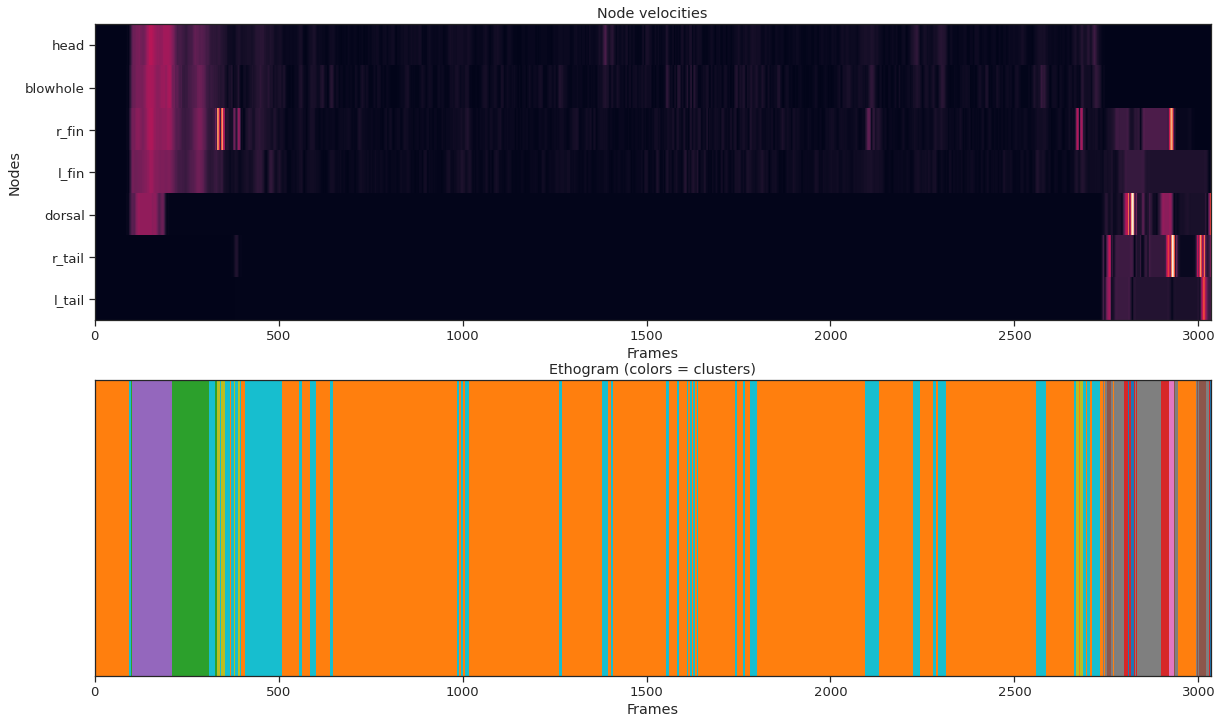

In [23]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(node_count))
ax1.set_yticklabels(node_names);
ax1.set_title(f"Node velocities")
ax1.set_xlim(0,frame_count)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");